# Customers Segmentation

In [4]:
import numpy as np
import pandas as pd
#pd.set_option('max_columns', 150)

import gc
import os

# matplotlib and seaborn for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120 #resolution
matplotlib.rcParams['figure.figsize'] = (8,6) #figure size

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
color = sns.color_palette()

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA

root = 'E:/01 MSBA UT/03 Fall/05 Marketing/Mid Sem Project/Raw Data/'

## Data

In [5]:
aisles = pd.read_csv(root + 'aisles.csv')
departments = pd.read_csv(root + 'departments.csv')
orders = pd.read_csv(root + 'orders.csv')
order_products_prior = pd.read_csv(root + 'order_products__prior.csv')
order_products_train = pd.read_csv(root + 'order_products__train.csv')
products = pd.read_csv(root + 'products.csv')

For segmentation I am considering users from prior set only

In [6]:
order_products = order_products_prior.merge(products, on ='product_id', how='left')
order_products = order_products.merge(aisles, on ='aisle_id', how='left')
order_products = order_products.merge(departments, on ='department_id', how='left')
order_products = order_products.merge(orders, on='order_id', how='left')
order_products.shape

(32434489, 15)

In [7]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [8]:
order_products.user_id.nunique()

206209

## Segmentation

Since there are thousands of products in the dataset I will rely on aisles, which represent categories of products. Even with aisles features will be too much so I will use Principal Component Analysis to find new dimensions along which clustering will be easier.

In [9]:
cross_df = pd.crosstab(order_products.user_id, order_products.department)
cross_df.head()

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,13,3,0,0,13,0,0,...,2,0,0,0,0,1,0,0,5,22
2,0,0,2,9,3,0,1,48,21,0,...,0,3,1,0,0,11,1,0,36,42
3,0,0,0,3,0,0,0,21,2,4,...,1,0,0,0,0,4,0,0,38,9
4,2,0,2,3,0,0,1,0,2,0,...,2,0,0,0,0,0,0,0,2,1
5,0,0,0,0,0,0,1,8,1,1,...,0,2,0,0,0,2,0,0,19,1


In [10]:
cross_df.tail()

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
206205,0,1,2,1,0,0,0,14,3,0,...,0,0,1,1,0,0,0,0,7,0
206206,0,0,2,33,1,0,9,39,5,1,...,12,4,2,0,1,14,10,0,34,42
206207,0,1,3,20,4,0,11,52,8,8,...,0,1,6,0,0,15,0,0,50,23
206208,0,3,62,20,17,0,11,161,28,17,...,6,3,22,2,0,38,5,0,197,59
206209,0,0,9,10,9,0,7,28,6,3,...,14,1,2,0,0,8,0,0,19,11


I will normalize each row

In [11]:
df = cross_df.div(cross_df.sum(axis=1), axis=0)
df.head()

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.000000,0.220339,0.050847,0.0,0.000000,0.220339,0.000000,0.000000,...,0.033898,0.000000,0.000000,0.0,0.0,0.016949,0.000000,0.0,0.084746,0.372881
2,0.000000,0.0,0.010256,0.046154,0.015385,0.0,0.005128,0.246154,0.107692,0.000000,...,0.000000,0.015385,0.005128,0.0,0.0,0.056410,0.005128,0.0,0.184615,0.215385
3,0.000000,0.0,0.000000,0.034091,0.000000,0.0,0.000000,0.238636,0.022727,0.045455,...,0.011364,0.000000,0.000000,0.0,0.0,0.045455,0.000000,0.0,0.431818,0.102273
4,0.111111,0.0,0.111111,0.166667,0.000000,0.0,0.055556,0.000000,0.111111,0.000000,...,0.111111,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.111111,0.055556
5,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.027027,0.216216,0.027027,0.027027,...,0.000000,0.054054,0.000000,0.0,0.0,0.054054,0.000000,0.0,0.513514,0.027027


In [35]:
df.shape

(206209, 134)

### PCA and K-Means Clustering

Reducing this dataframe to only 10 dimensions as KMeans does not work properly in higher dimension. 

In [12]:
pca = PCA(n_components=10)
df_pca = pca.fit_transform(df)
df_pca = pd.DataFrame(df_pca)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.266583,-0.047786,0.080290,-0.257217,0.030891,-0.029287,-0.019689,-0.036053,0.015083,-0.008036
1,-0.096643,0.102128,0.071972,-0.100870,0.050269,0.005953,-0.002581,-0.003230,-0.035350,0.077054
2,0.157813,0.059159,-0.010402,-0.066775,0.040580,-0.023734,-0.015206,-0.041654,-0.006096,0.015070
3,-0.180554,-0.104256,0.047553,0.162761,0.000880,-0.062219,0.113250,0.046428,-0.057027,0.023036
4,0.261321,0.058563,-0.035833,-0.020320,0.016724,-0.006359,-0.006824,-0.028631,0.006379,0.019848


In [29]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_pca)
    Sum_of_squared_distances.append(km.inertia_)

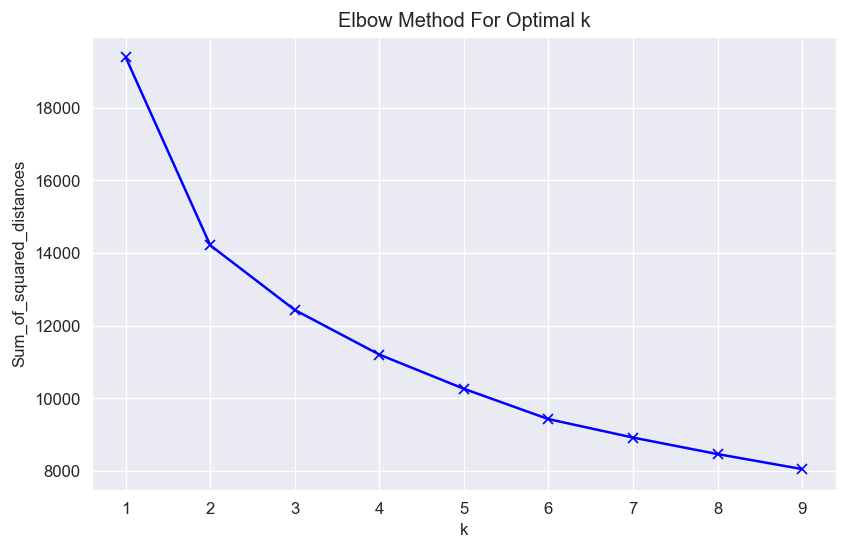

In [30]:
plt.subplots(figsize = (8, 5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From above plot we can choose optimal K as 5

In [85]:
clusterer = KMeans(n_clusters=4,random_state=42).fit(df_pca)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(df_pca)
print(centers)

[[-1.73635993e-01  3.98548204e-02  4.07542037e-02  1.67816669e-02
  -5.06022549e-03 -5.11969472e-03  1.53922164e-03 -1.95130785e-03
  -1.72750238e-03 -1.47038515e-03]
 [-2.85876753e-01 -2.62426725e-01 -1.31396047e-01 -4.44569145e-02
   2.05381083e-02  9.43833540e-04 -4.13908144e-03 -6.07718361e-03
  -1.11772074e-04  1.37057681e-04]
 [ 4.54050832e-02  3.54375462e-02 -1.27944127e-02 -3.96162543e-03
   5.79526390e-04  7.48679637e-03 -5.86900435e-05  5.34936881e-03
   1.93430198e-03  1.64886485e-03]
 [ 2.84728556e-01 -5.65778787e-02  2.68794429e-03 -4.85678126e-03
   4.52725921e-04 -7.87869711e-03 -1.07990597e-03 -6.25948258e-03
  -1.24607549e-03 -1.14184447e-03]]


#### Visualizing clustering among first two principal components

In [86]:
temp_df = df_pca.iloc[:, 0:2]
temp_df.columns = ["pc1", "pc2"]
temp_df['cluster'] = c_preds
temp_df.head()

C:\Users\shrey\AppData\Local\Temp\ipykernel_13848\1558269435.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['cluster'] = c_preds


,pc1,pc2,cluster
0,-0.266583,-0.047786,0
1,-0.096643,0.102128,0
2,0.157813,0.059159,2
3,-0.180554,-0.104256,0
4,0.261321,0.058563,3


In [75]:
set(c_preds)

{0, 1, 2}

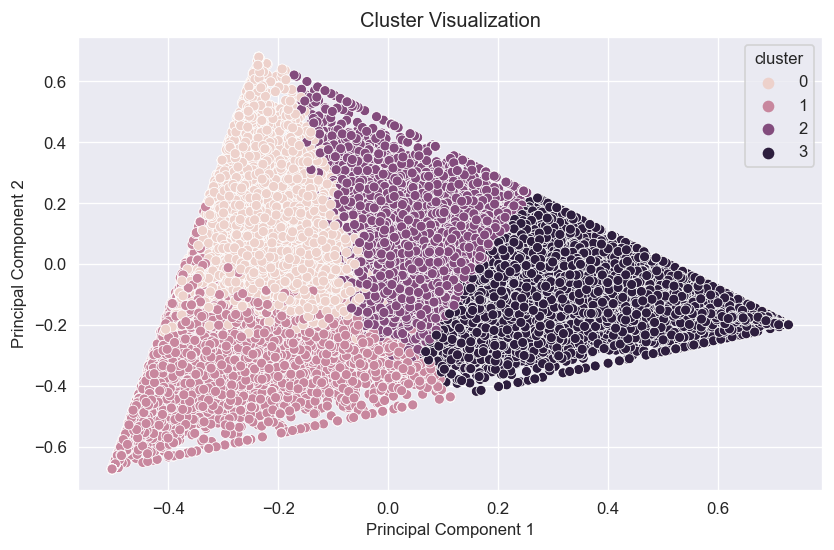

In [87]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.scatterplot(data = temp_df, x = "pc1", y = "pc2", hue = "cluster")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Cluster Visualization")
plt.show();

### Top products per cluster

In [42]:
cross_df.head()

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,13,3,0,0,13,0,0,...,0,0,0,0,1,0,0,5,22,0
2,0,0,2,9,3,0,1,48,21,0,...,3,1,0,0,11,1,0,36,42,0
3,0,0,0,3,0,0,0,21,2,4,...,0,0,0,0,4,0,0,38,9,2
4,2,0,2,3,0,0,1,0,2,0,...,0,0,0,0,0,0,0,2,1,0
5,0,0,0,0,0,0,1,8,1,1,...,2,0,0,0,2,0,0,19,1,3


In [88]:
cross_df['cluster'] = c_preds

In [89]:
cross_df_2 = cross_df.reset_index()
cross_df_2 = cross_df_2[['user_id','cluster']]
cross_df_2.head()

department,user_id,cluster
0,1,0
1,2,0
2,3,2
3,4,0
4,5,3


In [ ]:
cross_df_2.to_csv("dept_clusers.csv")

In [78]:
order_products_2 = order_products.merge(cross_df_2, how='left',on='user_id')
order_products_2.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,cluster
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0,0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0,0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0,0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0,0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0,0


In [79]:
order_products_2['cluster'].value_counts()

0    17172791
1    12714734
2     2546964
Name: cluster, dtype: int64

In [80]:
cross_df_3 = pd.crosstab(order_products_2.aisle, order_products_2.cluster)
cross_df_3.head()

cluster,0,1,2
aisle,,,
air fresheners candles,12936,2568,4347
asian foods,89203,67166,10238
baby accessories,5343,2311,506
baby bath body care,5866,2174,541
baby food formula,271003,103846,7607


In [81]:
cross_df_3.reset_index(inplace=True)


In [52]:
cross_df_3.head()

cluster,aisle,0,1,2,3
0,air fresheners candles,12516,1280,5071,984
1,asian foods,45153,3993,88939,28522
2,baby accessories,2879,155,4405,721
3,baby bath body care,3608,129,4147,697
4,baby food formula,115723,1917,238550,26266


In [82]:
cross_df_3[['aisle',0]].sort_values(by=0,ascending=False)

cluster,aisle,0
50,fresh fruits,1461410
53,fresh vegetables,1169672
133,yogurt,912026
98,packaged vegetables fruits,742252
93,packaged cheese,603315
...,...,...
115,skin care,5691
76,kitchen supplies,5428
2,baby accessories,5343
8,beauty,3940


In [83]:
cross_df_3[['aisle',1]].sort_values(by=1,ascending=False)

cluster,aisle,1
53,fresh vegetables,2205748
50,fresh fruits,2049272
98,packaged vegetables fruits,973804
133,yogurt,455999
93,packaged cheese,332135
...,...,...
114,shave needs,1063
44,eye ear care,1016
45,facial care,979
58,frozen juice,848


In [84]:
cross_df_3[['aisle',2]].sort_values(by=2,ascending=False)

cluster,aisle,2
131,water seltzer sparkling water,244327
50,fresh fruits,131506
117,soft drinks,127296
110,refrigerated,113147
25,chips pretzels,106825
...,...,...
3,baby bath body care,541
2,baby accessories,506
58,frozen juice,498
113,seafood counter,404


In [65]:
cross_df_3[['aisle',3]].sort_values(by=3,ascending=False)

cluster,aisle,3
53,fresh vegetables,1192996
50,fresh fruits,1056170
98,packaged vegetables fruits,492230
133,yogurt,157065
96,packaged produce,153699
...,...,...
123,spirits,445
45,facial care,436
58,frozen juice,415
114,shave needs,385


In [49]:
cross_df_3.to_csv("clusters_asile.csv")

In [36]:
cross_df['cluster'] = c_preds

cluster1 = cross_df[cross_df.cluster == 0]
cluster2 = cross_df[cross_df.cluster == 1]
cluster3 = cross_df[cross_df.cluster == 2]
cluster4 = cross_df[cross_df.cluster == 3]
cluster5 = cross_df[cross_df.cluster == 4]

In [93]:
cluster1.shape

(5428, 135)

In [37]:
cluster1.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

department
dairy eggs      23.371717
snacks          18.259786
produce         16.931136
beverages       14.363808
frozen          13.514254
pantry           8.766415
bakery           6.137982
household        5.825526
deli             4.608389
canned goods     4.416913
dtype: float64

In [95]:
cluster2.shape

(55784, 135)

In [38]:
cluster2.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

department
beverages     32.558509
snacks        11.653071
dairy eggs     9.296899
produce        8.287580
household      3.083715
frozen         2.964024
pantry         2.901237
breakfast      1.796364
bakery         1.717232
deli           1.653987
dtype: float64

In [97]:
cluster3.shape

(7948, 135)

In [39]:
cluster3.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

department
produce            60.333202
dairy eggs         35.242851
snacks             14.392091
frozen             12.308257
beverages          12.252314
pantry             11.213789
bakery              7.156338
canned goods        6.727183
deli                6.710089
dry goods pasta     5.540172
dtype: float64

In [99]:
cluster4.shape

(37949, 135)

In [40]:
cluster4.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

department
produce         75.700688
dairy eggs      17.271280
pantry           7.112205
snacks           6.853035
beverages        6.192066
frozen           5.834297
canned goods     4.533913
deli             3.571987
bakery           3.176343
meat seafood     3.098450
dtype: float64

In [101]:
cluster5.shape

(99100, 135)

In [41]:
cluster5.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

department
alcohol           NaN
babies            NaN
bakery            NaN
beverages         NaN
breakfast         NaN
bulk              NaN
canned goods      NaN
dairy eggs        NaN
deli              NaN
dry goods pasta   NaN
dtype: float64